# 1D-signal data augmentation for regression problem
https://github.com/fdesmond/seme-ts

**This version uses the log of the target variables**
Taking the log of y improves all the results (in R2 score).

Updates usign **xgboost + distortion of y**: we obtain worse results than RandomForest, he distortion to y is not helping at all (statistically worse in mean).

To try:
- make this problem classification and/or use different dataset.
- histogram of scores when n is very small, augmenting the dataset helps improving the "stability"?
- trying with a fake dataset with known correlations (e.g., by generating random variable and applying a known function)

In [1]:
# standard module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb    #XGBOOST EVERYTHING!
plt.style.use('ggplot')
%matplotlib inline

# tsmall module
from tsmall import *

## The energy dataset
As a first example, we consider the [Appliances energy prediction Data Set](https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction). The dataset is ready-to-use, however, we filter the most important features following the related publication [Data driven prediction models of energy use of appliances in a low-energy house](https://www.sciencedirect.com/science/article/pii/S0378778816308970?via%3Dihub).

The `data_A` is a filtered version of the original dataset. Observe that
- the target variable `Y` is given by the `Appliances` feature
- the `date` column is used as a index: we are not going to exploit the time-series properties of the features, but only ther 1d-signal nature (see below in Data Augmentation to build `data_C`)

In [2]:
energy = pd.read_csv('energy_data.csv', parse_dates=['date'])
energy.set_index('date', inplace=True)

# most important columns, Appliances put in the end
ts_index = ['T1', 'RH_1', 'T2', 'RH_2', 'T3', 'RH_3', 'T4',
       'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8', 'RH_8', 'T9',
       'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Tdewpoint', 'Appliances']

data_A = energy[ts_index].iloc[2000:5000].copy()
data_A['Appliances'] = np.log(energy['Appliances'].iloc[2000:5000])
display(data_A.head(), data_A.describe())

,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Tdewpoint,Appliances
date,,,,,,,,,,,,,,,,,,,,,
2016-01-25 14:20:00,20.426667,43.400000,19.500000,43.090000,20.29,44.400000,18.20,45.00,18.290000,47.700,...,19.500000,46.000000,17.0,48.9,12.833333,762.233333,55.666667,5.0,4.166667,3.401197
2016-01-25 14:30:00,20.500000,43.326667,19.500000,43.090000,20.29,44.363333,18.23,45.03,18.290000,47.700,...,19.516667,45.898333,17.0,48.9,12.900000,762.200000,55.500000,5.0,4.200000,2.995732
2016-01-25 14:40:00,20.600000,43.200000,19.533333,43.090000,20.29,44.290000,18.29,45.09,18.301111,47.700,...,19.650000,45.745000,17.0,48.9,12.966667,762.166667,55.333333,5.0,4.233333,3.688879
2016-01-25 14:50:00,20.666667,43.200000,19.600000,43.090000,20.29,44.290000,18.29,45.09,18.351111,47.700,...,19.780556,45.598333,17.0,48.9,13.033333,762.133333,55.166667,5.0,4.266667,4.094345
2016-01-25 15:00:00,20.700000,43.200000,19.700000,43.126667,20.29,44.317500,18.29,45.03,18.390000,47.755,...,19.897222,45.535000,17.0,48.9,13.100000,762.100000,55.000000,5.0,4.300000,3.912023


,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Tdewpoint,Appliances
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,...,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,21.064836,43.904870,20.224685,42.854233,21.343446,43.549742,19.454035,44.138490,18.689429,56.859562,...,20.706924,48.502279,17.996975,46.046660,6.598239,752.133772,86.637167,5.931500,4.418528,4.252179
std,1.231670,2.547823,1.342911,2.054042,1.170901,1.926925,1.247989,3.056481,1.101539,9.154033,...,1.741227,3.990819,0.904739,3.501519,3.044054,9.819397,8.605977,2.762049,2.846681,0.716682
min,17.890000,37.500000,17.100000,36.663333,18.823333,38.090000,16.390000,36.900000,16.600000,45.601667,...,16.890000,38.018889,16.100000,37.363333,-0.300000,729.300000,55.000000,1.000000,-1.900000,2.302585
25%,20.290000,42.355625,19.290000,41.290000,20.500000,42.200000,18.790000,41.756875,17.804444,51.590000,...,19.785000,45.382222,17.100000,43.433333,3.750000,743.545833,81.666667,4.000000,2.100000,3.688879
50%,21.166667,43.900000,20.356667,42.863333,21.390000,44.000000,19.390000,44.108333,18.710000,54.143889,...,21.038889,48.905556,18.200000,46.528333,6.933333,754.600000,89.000000,5.666667,3.875000,4.094345
75%,21.890000,45.472500,21.166667,44.200000,22.100000,44.900000,20.290000,46.400000,19.329306,58.817500,...,21.964861,51.157222,18.790000,48.900000,9.233333,760.133333,93.000000,8.000000,6.900000,4.605170
max,24.100000,63.360000,23.600000,50.260000,25.500000,49.560000,23.000000,51.090000,22.967778,96.321667,...,24.290000,58.780000,19.290000,53.326667,13.100000,766.000000,99.000000,14.000000,10.700000,6.659294


#### quick EDA 
A few plots to grasp the dataset structure.

[Text(0.5, 0, 'log(Appliances)'), Text(0.5, 1.0, 'Histogram')]

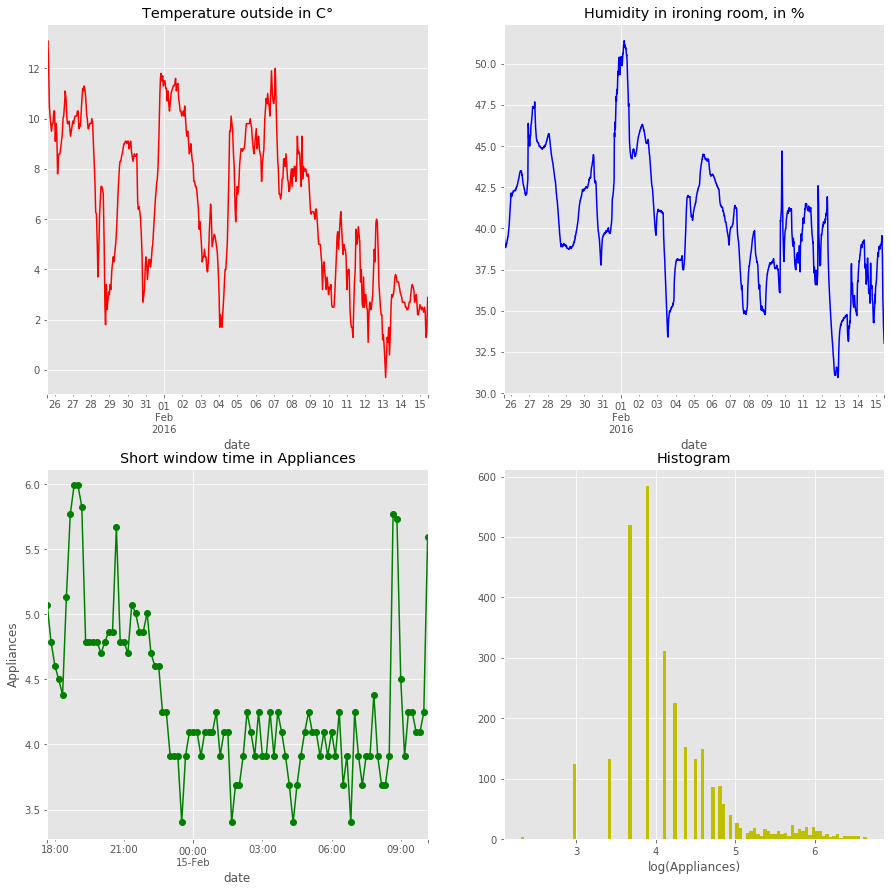

In [3]:
fig, ax = plt.subplots(figsize=[15,15], nrows=2, ncols=2)
data_A.T_out.plot(ax=ax[0,0], title='Temperature outside in C°', color='r')
data_A.RH_7.plot(ax=ax[0,1], title='Humidity in ironing room, in %', color='b')
data_A.Appliances.iloc[-100:].plot(marker='o', color='g', title='Short window time in Appliances', ax=ax[1,0]).set(ylabel='Appliances')
data_A.Appliances.hist(bins=100, ax=ax[1,1], color='y').set(title='Histogram', xlabel='log(Appliances)')

### obtaining `data_B` and `data_C` 

In [4]:
# train-test-split of data_A
y_A = data_A.Appliances
X_A = data_A.drop(columns='Appliances')
xtrain_A, xtest_A, ytrain_A, ytest_A = train_test_split(X_A, y_A, test_size=0.2, random_state=42)

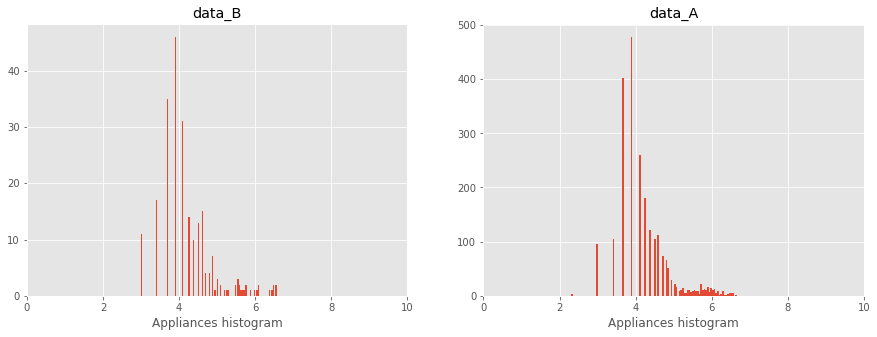

In [5]:
p = 0.1 # the propotion by which we sample the data from data_A
xtrain_B = xtrain_A.sample(frac = p)
ytrain_B = ytrain_A.loc[xtrain_B.index]

xtest_B = xtest_A.sample(frac = p)
ytest_B = ytest_A.loc[xtest_B.index]

# visually check that the data_B has a similar Appliances histogram
fig, ax = plt.subplots(figsize=[15,5], nrows=1, ncols=2)
ax[0].set(title='data_B', xlabel='Appliances histogram', xlim=[0,10])
ax[1].set(title='data_A', xlabel='Appliances histogram', xlim=[0,10])

ytrain_B.hist(bins=100, ax=ax[0])
ytrain_A.hist(bins=100, ax=ax[1])

#### data augmentation
Data augmentation is performed by `dfaug()` and `tsaug()` functions in `tsmall.augment`. The output, `data_C`, is a dataframe consisting in the original dataframe, i.e., `data_B`, plus a distorted version of it. The distortion is made by the function `tsaug()` applied to a randomly selected time window of a feature (iterating on time-windows and features): it consists in applying white noise to the phase at the level of the [FFT](https://en.wikipedia.org/wiki/Fast_Fourier_transform) and inverting the signal back using the inverse FFT (IFFT).

In [6]:
train_C = dfaug(pd.concat([xtrain_B, ytrain_B], axis=1), sigma=0.5, method='wavelet', y_dist=True) # sigma tunes the distortion

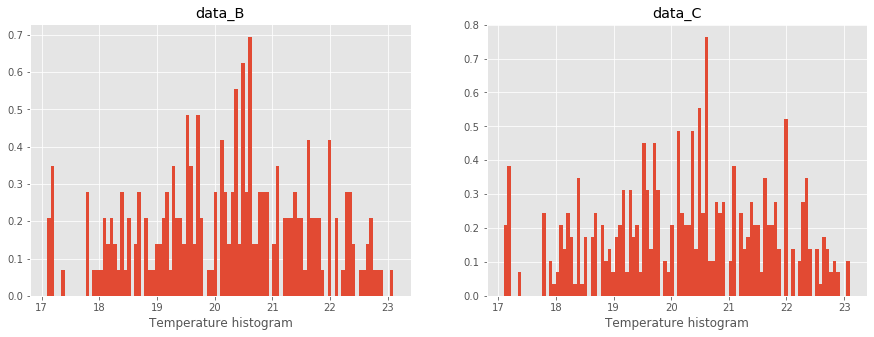

In [7]:
# visually check that the data_B has a similar Appliances histogram
fig, ax = plt.subplots(figsize=[15,5], nrows=1, ncols=2)
ax[0].set(title='data_B', xlabel='Temperature histogram')
ax[1].set(title='data_C', xlabel='Temperature histogram')

xtrain_B.T2.hist(bins=100, ax=ax[0], density=True)
train_C.T2.hist(bins=100, ax=ax[1], density=True)

### model fitting: data_A

In [8]:
#rf_A = xgb.XGBRegressor(n_jobs = -1)
rf_A = RandomForestRegressor(n_jobs=-1)
rf_A.fit(xtrain_A, ytrain_A)
rmse_AA = mean_squared_error(ytest_A, rf_A.predict(xtest_A), squared=False)
R2_AA = rf_A.score(xtest_A, ytest_A)

### model fitting: data_B, data_C

In [9]:
R2_B = np.zeros(shape = (30,2))
R2_C = np.zeros(shape = (30,2))
rmse_B = np.zeros(shape = (30,2))
rmse_C = np.zeros(shape = (30,2))
rmse_star = np.zeros(30)     # related to y_star which is ypred_B + np.abs(ypred_B - ypred_C)
for k in range(30):  
    # sample data_B
    xtrain_B = xtrain_A.sample(frac = p, random_state=k)
    ytrain_B = ytrain_A.loc[xtrain_B.index]

    xtest_B = xtest_A.sample(frac = p, random_state=k)
    ytest_B = ytest_A.loc[xtest_B.index]

    # data augmentation data_C
    train_C = dfaug(pd.concat([xtrain_B, ytrain_B], axis=1), sigma=1, method='wavelet', y_dist=False) 

    ytrain_C = train_C.Appliances
    xtrain_C = train_C.drop(columns='Appliances')
    
    # model fitting
    rf_B = RandomForestRegressor(n_jobs = -1)
    rf_B.fit(xtrain_B, ytrain_B)

    rf_C = RandomForestRegressor(n_jobs = -1)
    rf_C.fit(xtrain_C, ytrain_C)
    
    R2_B[k, 0] = rf_B.score(xtest_B, ytest_B)
    rmse_B[k, 0] = mean_squared_error(ytest_B, rf_B.predict(xtest_B), squared=False)
    R2_B[k, 1] = rf_B.score(xtest_A, ytest_A)
    rmse_B[k, 1] = mean_squared_error(ytest_A, rf_B.predict(xtest_A), squared=False)
    R2_C[k, 0] = rf_C.score(xtest_B, ytest_B)
    rmse_C[k, 0] = mean_squared_error(ytest_B, rf_C.predict(xtest_B), squared=False)
    R2_C[k, 1] = rf_C.score(xtest_A, ytest_A)
    rmse_C[k, 1] = mean_squared_error(ytest_A, rf_C.predict(xtest_A), squared=False)
    rmse_star[k] = mean_squared_error(ytest_A, rf_B.predict(xtest_A) + np.abs(rf_B.predict(xtest_A) - rf_C.predict(xtest_A)), squared=False)

### Results

In [10]:
display('model_A, train on train_A, test on test_A MSE: {: .2f}, R2 score: {:.2f}'.format(rmse_AA,R2_AA))

'model_A, train on train_A, test on test_A MSE:  0.35, R2 score: 0.76'

In [11]:
display('model_B, train on train_B, test on test_B MSE: {: .2f}, R2 score: {:.3f} (30 times average)'.format(rmse_B[:,0].mean(), R2_B[:,0].mean()),\
        'model_B, train on train_B, test on test_A MSE: {: .2f}, R2 score: {:.3f} (30 times average)'.format(rmse_B[:,1].mean(), R2_B[:,1].mean()))

'model_B, train on train_B, test on test_B MSE:  0.53, R2 score: 0.423 (30 times average)'

'model_B, train on train_B, test on test_A MSE:  0.55, R2 score: 0.432 (30 times average)'

In [12]:
display('model_C, train on train_C, test on test_B MSE: {: .2f}, R2 score: {:.3f} (30 times average)'.format(rmse_C[:,0].mean(), R2_C[:,0].mean()),\
        'model_C, train on train_C, test on test_A MSE: {: .2f}, R2 score: {:.3f} (30 times average)'.format(rmse_C[:,1].mean(), R2_C[:,1].mean()))

'model_C, train on train_C, test on test_B MSE:  0.54, R2 score: 0.412 (30 times average)'

'model_C, train on train_C, test on test_A MSE:  0.55, R2 score: 0.420 (30 times average)'

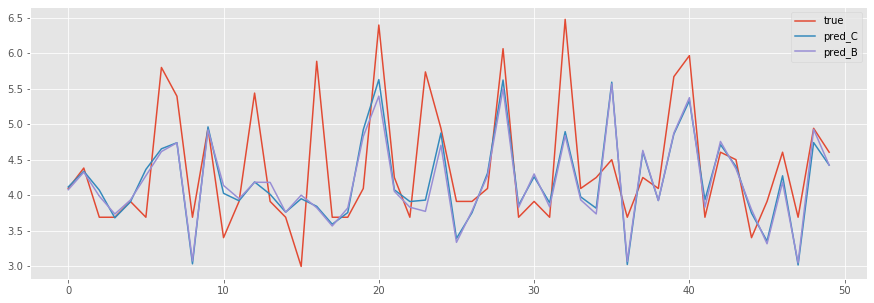

In [13]:
plt.rcParams['figure.figsize'] = [15, 5]
s=200
i=50
plt.plot(range(i), ytest_A[s:s+i], label = "true")
plt.plot(range(i), rf_C.predict(xtest_A[s:s+i]), label = "pred_C")
plt.plot(range(i), rf_B.predict(xtest_A[s:s+i]), label = "pred_B")
#plt.plot(range(i), rf_A.predict(xtest_A[s:s+i]), label = "pred_A")
plt.legend()

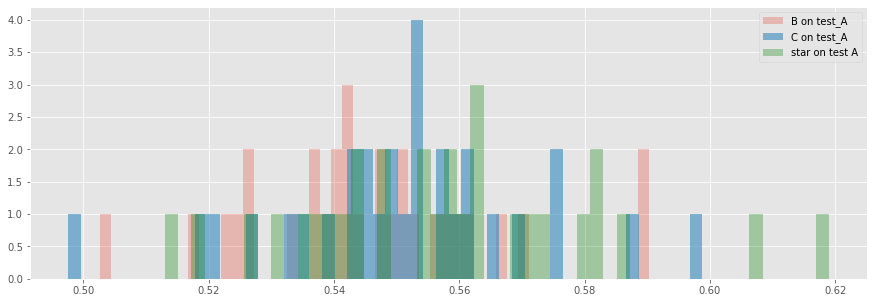

In [14]:
fig, ax = plt.subplots(figsize=[15,5], nrows=1, ncols=1)
#plt.hist(rmse_B[:,0], bins = 50, alpha=.5, label='B on test_B')
plt.hist(rmse_B[:,1], bins = 50, alpha=.3, label='B on test_A')
#plt.hist(rmse_C[:,0], bins = 50, alpha=.5, label='C on test_B')
plt.hist(rmse_C[:,1], bins = 50, alpha=.6, label='C on test_A')
plt.hist(rmse_star, bins=50, alpha=.3, label='star on test A', color='g')
plt.legend()

In [15]:
y_star = rf_B.predict(xtest_A) + np.abs(rf_B.predict(xtest_A) - rf_C.predict(xtest_A))
print(mean_squared_error(ytest_A, y_star, squared=False))

0.5317544655833654
